#### Load required libraries

In [126]:
import numpy as np
import logging
import pickle
# required libraries for Reconstructor matrix computation or MPC
from scipy import sparse

# Define color and marker for analysis plots
markers = ["x", "+", "o"]
colors = ["blue","orange","green","red","purple","brown","pink"]

import os.path
from os import path

from pathlib import Path
# import DOS library
import dos
import dos.plot_tools as ptools

from ruamel import yaml
from ruamel.yaml import YAML
y = YAML()
y.default_flow_style = None

sim_folder = 'dos/SHWFS'
calibDataFolder = '/Users/rromano/Workspace/SIMCEO/calibration_dbs'

#### Update DOS settings

In [127]:
rec_inputs = {'SH-WFS': {'lien': ['wfs48', 'data']},
              'uM1T': {'lien': ['AcO_controller', 'M1 Txyz']},
              'uM1R': {'lien': ['AcO_controller', 'M1 Rxyz']},
              'uM2T': {'lien': ['AcO_controller', 'M2 Txyz']},
              'uM2R': {'lien': ['AcO_controller', 'M2 Rxyz']},
              'uM1BM': {'lien': ['AcO_controller', 'M1 BM']}
             }

with open(Path(sim_folder)/'dos.yaml','r') as stream:
        dos_setup_dt = yaml.safe_load(stream)

dos_setup_dt['simulation']['duration'] = 50
dos_setup_dt['simulation']['server']['IP'] = '54.200.122.185'
dos_setup_dt['drivers']['ReconstructorM']['inputs'] = rec_inputs


In [128]:
rec_inputs

{'SH-WFS': {'lien': ['wfs48', 'data']},
 'uM1T': {'lien': ['AcO_controller', 'M1 Txyz']},
 'uM1R': {'lien': ['AcO_controller', 'M1 Rxyz']},
 'uM2T': {'lien': ['AcO_controller', 'M2 Txyz']},
 'uM2R': {'lien': ['AcO_controller', 'M2 Rxyz']},
 'uM1BM': {'lien': ['AcO_controller', 'M1 BM']}}

In [129]:
with open(Path(sim_folder)/'dos.yaml','w') as f:
        y.dump(dos_setup_dt, f)

In [101]:
# Reload plot tools library
import importlib
importlib.reload(dos.plot_tools)

<module 'dos.plot_tools' from '/Users/rromano/Workspace/SIMCEO/dos/plot_tools.py'>

In [112]:
# Reload DOS library
import importlib
importlib.reload(dos.tools)

<module 'dos.tools' from '/Users/rromano/Workspace/SIMCEO/dos/tools.py'>

#### Compute reconstructor from interacion matrix

In [113]:
n_bm = 27

In [114]:
# * * * Flag to control if reconstructor matrix is updated * * *
updateReconst = True

if (not path.exists(sim_folder+'/ReconstructorM.pickle')) or (updateReconst):
    # Load calibration data
    dt = np.load(Path(calibDataFolder)/'calib_dt_GSH0p5fluxTH_46BM.npz', allow_pickle=True)
    
    # Compute AcO reconstructor using decoupled strategy
    Msimceo = dos.tools.build_AcO_Rec(dt['calibdt'][()]['D'],
                                      n_bm=n_bm, 
                                      rec_alg = 'RLS',#TSVD
                                      wfsMask=dt['calibdt'][()]['wfsMask'])

    # Compute AcO reconstructor using consolidated interaction matrix
    #Dsh = dos.tools.get_SHWFS_D(dt['calibdt'][()]['D'], includeM1S7Rz_col=True)
    #n_bm = (Dsh.shape[1] - 82)//7
    #if((Dsh.shape[1] - 82)%7):
    #    print('Noninteger result in n_bm computation!')
    #M = dos.tools.build_TSVD_RecM(Dsh,  n_r=12)
    #Msimceo = dos.tools.gen_recM_4_SIMCEO(M, dt['calibdt'][()]['wfsMask'])
    
    # Generate SIMCEO reconstructor pickle file
    dos.tools.linear_estimator_2_dos(Msimceo,sim_folder+'/ReconstructorM', B_or_D='D')
    # dos.tools.linear_estimator_2_dos(np.eye(Msimceo.shape[0]),sim_folder+'/ReconstructorM', B_or_D='D')
    print('SH-WFS reconstructor matrix pickle file is updated!')
    print('SIMCEO reconstructor matrix dimensions:', Msimceo.shape)

27 BMs used in the reconstructor computation.
5.9077213918591625e-05
5.9077213918591625e-05
5.9077213918591625e-05
5.9077213918591625e-05
5.9077213918591625e-05
5.9077213918591625e-05
6.358491765753166e-05
No reconstructor matrix row reordering!
SH-WFS reconstructor matrix pickle file is updated!
SIMCEO reconstructor matrix dimensions: (273, 13824)


In [76]:
w_M1TxyzRxyz = np.diag(np.array([1,1,1,4,4,4])) #
w_M2TxyzRxyz = np.diag(np.array([50,40,40,8,8,8]))
w_M1BM = 0.1*np.eye(n_bm)

from scipy.linalg import block_diag

W2 = block_diag(w_M1TxyzRxyz, w_M2TxyzRxyz, w_M1BM)
W2norm = np.linalg.norm(W2)
np.linalg.norm(W2), np.trace(W2), np.linalg.norm((1/W2norm)*W2)

(77.09260664940577, 171.69999999999996, 0.9999999999999994)

In [ ]:
with open(Path(sim_folder)/'wfs48.yaml','r') as stream:
        wfs48_dt = yaml.safe_load(stream)
wfs48_dt['source']['magnitude'] = [6,6,6]
wfs48_dt['sensor']['args']['readOutNoiseRms'] = 0.5
with open(Path(sim_folder)/'wfs48.yaml','w') as f:
        y.dump(wfs48_dt, f)

In [86]:
with open(Path(sim_folder)/'AcO_controller.yaml','r') as stream:
        aco_ctrl_dt = yaml.safe_load(stream)
aco_ctrl_dt['System']['parameters']['num'] = [-0.15]
with open(Path(sim_folder)/'AcO_controller.yaml','w') as f:
        y.dump(aco_ctrl_dt, f)

#### Set initial M1/M2 states and generate respective yaml files

In [132]:
# Python code to set simulation states
from ruamel import yaml
from ruamel.yaml import YAML

#test_case = 's1_curvature_error'
test_case = 's1_curvature_error'

if 'm1_x0_dt' in locals():
    del m1_x0_dt
if 'm2_x0_dt' in locals():
    del m2_x0_dt    

if(test_case == 's1_curvature_error'):
    # Load M1 and M2 inital states dictionaties
    with open(Path(sim_folder)/'M1_ceS1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
    with open(Path(sim_folder)/'M2_ceS1.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)
#        
elif(test_case == 'fully_aligned'):
    # Load M1 and M2 inital states dictionaties
    with open(Path(sim_folder)/'M1_ceS1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
    with open(Path(sim_folder)/'M2_ceS1.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)
    m1_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['Rxyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['modes'] = np.zeros((7,n_bm)).tolist()
    m2_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m2_x0_dt['state']['Rxyz'] =  np.zeros((7,3)).tolist()
#        
elif(test_case == 'BM_dist'):
    # Load M1 and M2 inital states dictionaties
    with open(Path(sim_folder)/'M1_ceS1.yaml','r') as stream:
        m1_x0_dt = yaml.safe_load(stream)
    with open(Path(sim_folder)/'M2_ceS1.yaml','r') as stream:
        m2_x0_dt = yaml.safe_load(stream)
    m1_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['Rxyz'] = np.zeros((7,3)).tolist()
    m1_x0_dt['state']['modes'] = np.zeros((7,n_bm)).tolist()
    m1_x0_dt['state']['modes'][0][2] = 5.0e-4
    m2_x0_dt['state']['Txyz'] = np.zeros((7,3)).tolist()
    m2_x0_dt['state']['Rxyz'] =  np.zeros((7,3)).tolist()
    
# Update number of M1 bending modes in yaml file
m1_x0_dt['mirror_args']['N_MODE'] = n_bm
    
with open(Path(sim_folder)/'M1.yaml','w') as f:
        y.dump(m1_x0_dt, f)
with open(Path(sim_folder)/'M2.yaml','w') as f:
        y.dump(m2_x0_dt, f)        

#### Instantiate DOS

In [130]:
sim = dos.DOS(sim_folder,verbose=logging.INFO,show_timing=2)

INFO:DOS:Reading config from dos/SHWFS/dos.yaml
INFO:DOS:New driver: M1
INFO:M1:New input: Txyz
INFO:M1:New input: Rxyz
INFO:M1:New input: modes
INFO:M1:No inputs!
INFO:DOS:New driver: M2
INFO:M2:New input: Txyz
INFO:M2:New input: Rxyz
INFO:M2:No inputs!
INFO:DOS:New driver: wfs48
INFO:wfs48:No inputs!
INFO:wfs48:New output: data
INFO:wfs48:New output: M12_RBM
INFO:wfs48:Output logged in!
INFO:DOS:New driver: ReconstructorM
INFO:ReconstructorM:New input: SH-WFS
INFO:ReconstructorM:New input: uM1T
INFO:ReconstructorM:New input: uM1R
INFO:ReconstructorM:New input: uM2T
INFO:ReconstructorM:New input: uM2R
INFO:ReconstructorM:New input: uM1BM
INFO:ReconstructorM:New output: x_hat
INFO:ReconstructorM:Output logged in!
INFO:DOS:New driver: AcO_controller
INFO:AcO_controller:New input: x_hat
INFO:AcO_controller:New output: M1 Txyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M1 Rxyz
INFO:AcO_controller:Output logged in!
INFO:AcO_controller:New output: M2 Txyz
INFO:AcO

SIMCEO server received: Acknowledging connection from SIMCEO client!


INFO:DOS:Simulation setup for a duration of 50s @ 1Hz (50 steps)!


In [136]:
# Start simulation
sim._run_()

INFO:DOS:Pushing configuration to server
INFO:M1:GMT
INFO:M2:GMT
INFO:wfs48:OP0
INFO:science:OP1
INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:science:None
INFO:DOS:Running
INFO:DOS:Terminating
INFO:M1:GMT deleted!
INFO:M2:GMT deleted!
INFO:wfs48:OpticalPath deleted!


Elapsed time: 28.239765167236328


INFO:science:OpticalPath deleted!


In [41]:
sim.pctComplete

100

In [42]:
sim.push()

INFO:DOS:Pushing configuration to server


In [6]:
sim.init()

INFO:DOS:Initializing
INFO:M1:None
INFO:M2:None
INFO:wfs48:None
INFO:science:None


In [7]:
sim.terminate()

INFO:DOS:Terminating
INFO:M1:GMT deleted!
INFO:M2:GMT deleted!
INFO:wfs48:OpticalPath deleted!
INFO:science:OpticalPath deleted!


In [104]:
sim.logs.entries.keys(), sim.logs

(dict_keys(['wfs48', 'ReconstructorM', 'AcO_controller', 'science']),
 The 'logs' has 13 entries:
  * wfs48
    1. M12_RBM: (273,)x30
  * ReconstructorM
    1. x_hat: (273,)x30
  * AcO_controller
    1. M1 Txyz: (7, 3)x30
    2. M1 Rxyz: (7, 3)x30
    3. M2 Txyz: (7, 3)x30
    4. M2 Rxyz: (7, 3)x30
    5. M1 BM: (7, 27)x30
  * science
    1. wfe_rms: (1,)x30
    2. segment_wfe_rms: (7,)x30
    3. PSSn: (1,)x30
    4. tiptilt: (2,)x30
    5. segment_piston: (7,)x30
    6. segment_tiptilt: (14,)x30)

In [89]:
sim.logs.entries['science']['segment_wfe_rms'].timeSeries[1][0,:]

array([5.59843193e-06, 7.71736230e-10, 7.71736453e-10, 7.71906428e-10,
       7.71736397e-10, 7.71736175e-10, 1.72432388e-10])


Final values:
 WFE: [14.95574331] 
 [0.75950818 0.77253332 0.77137258 0.77249568 0.77255119 0.77115231
 0.1724248 ] 
PSSn: [0.99999985] 
sum of abs seg piston: 0.044470054916256885 
 [-0.0423044   0.00035745 -0.00063316 -0.00018526  0.00026776  0.00030057
  0.00042145]



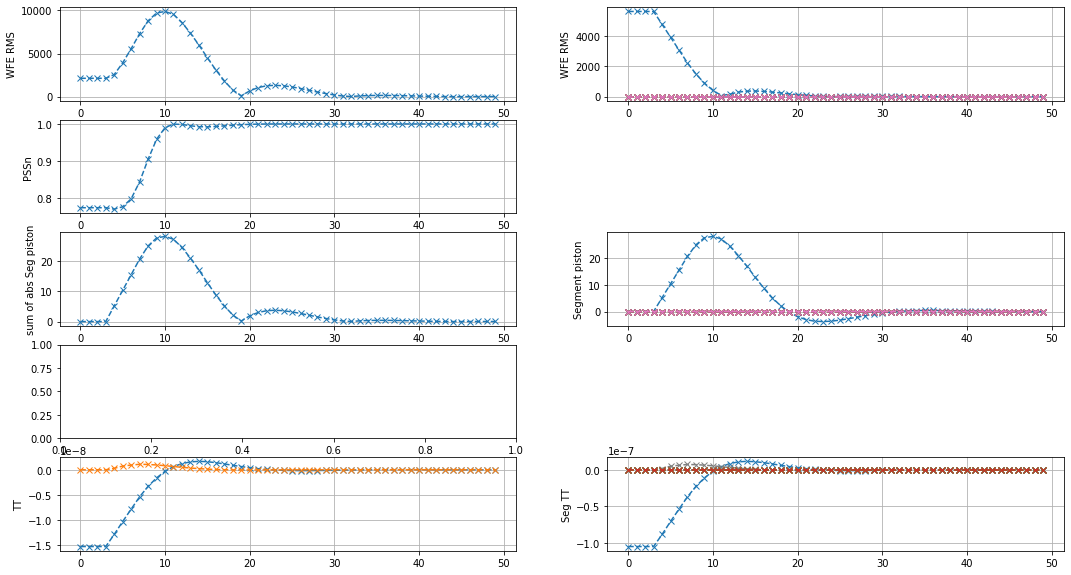

In [90]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])


Final values:
 WFE: [1324.37503453] 
 [0.875503   0.77181694 0.7713622  0.77188084 0.77218776 0.77161955
 0.17241113] 
PSSn: [0.9999998] 
sum of abs seg piston: 3.7604462801155147 
 [-3.75891818e+00 -1.98305428e-04 -2.45068382e-04 -1.71907419e-04
 -2.23403560e-04 -2.16083734e-04  4.73328654e-04]



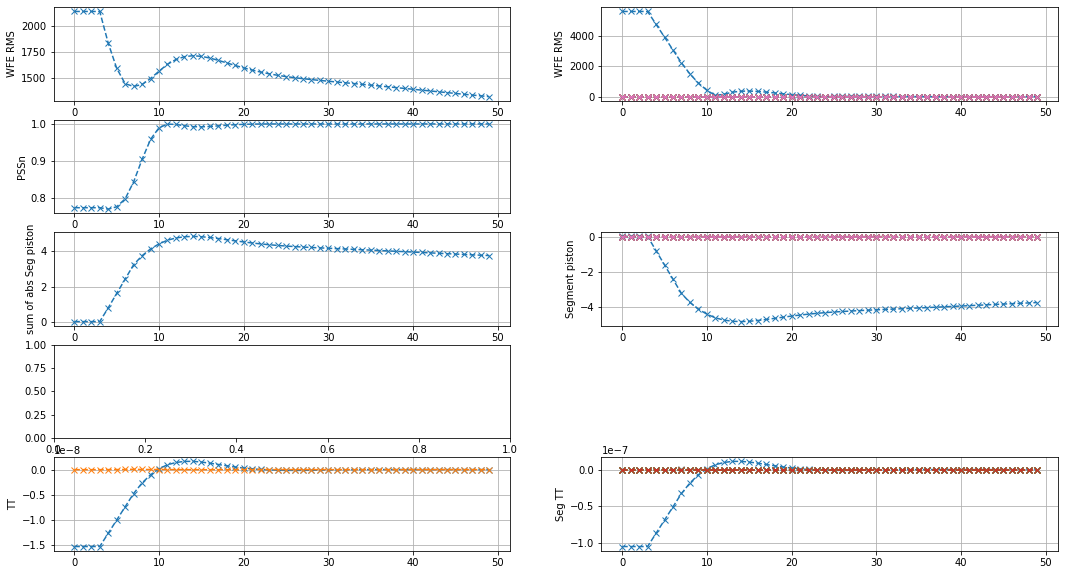

In [110]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])


Final values:
 WFE: [128.16870765] 
 [0.77222734 0.77185536 0.77134682 0.77190426 0.77216478 0.77163081
 0.17241149] 
PSSn: [0.99999988] 
sum of abs seg piston: 0.3649857222252917 
 [ 3.63690731e-01 -1.75795697e-05 -3.64948127e-04 -4.05423577e-05
 -3.19348964e-04 -7.92221497e-05  4.73350192e-04]



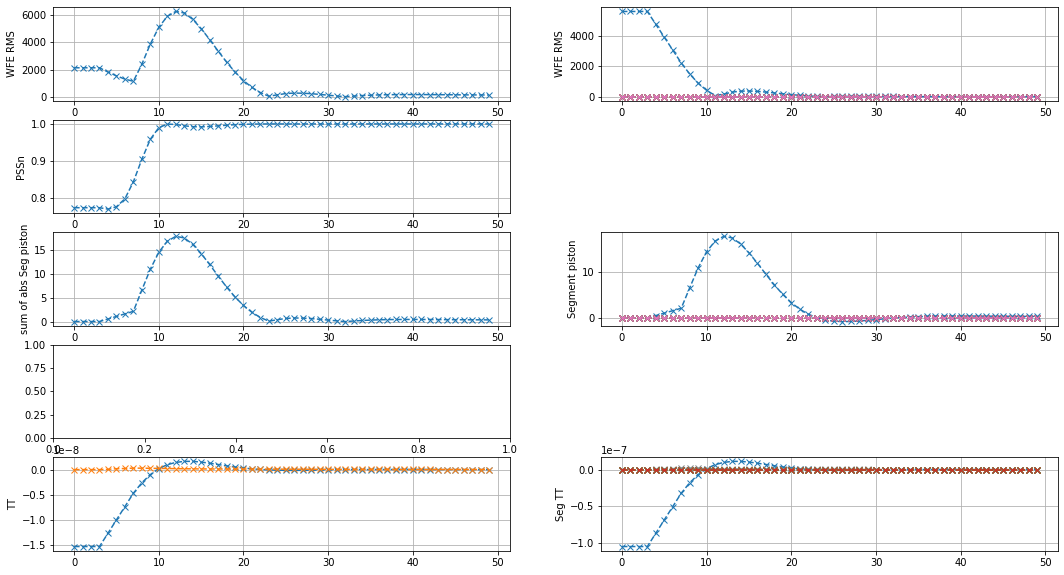

In [117]:
ptools.plot_science(sim.logs.entries['science'], m1EsDT=[])

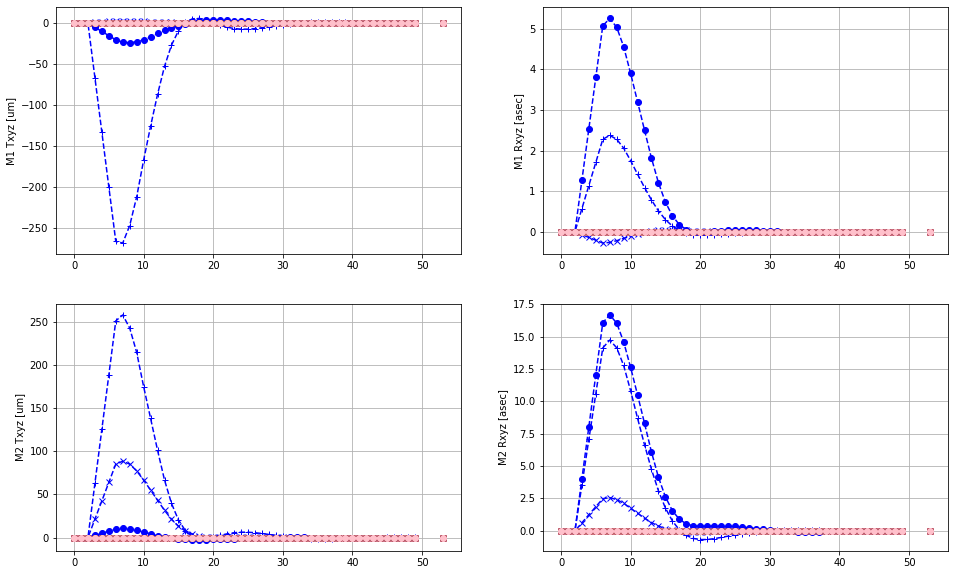

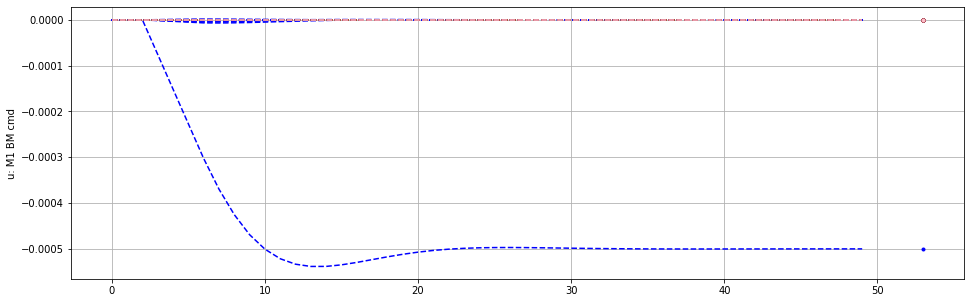

In [91]:
U = sim.logs.entries['AcO_controller']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

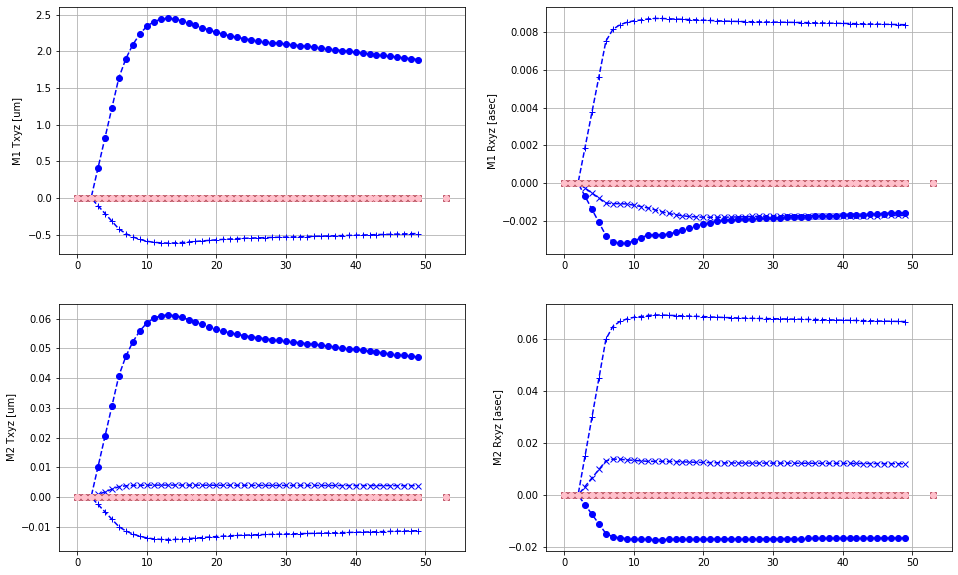

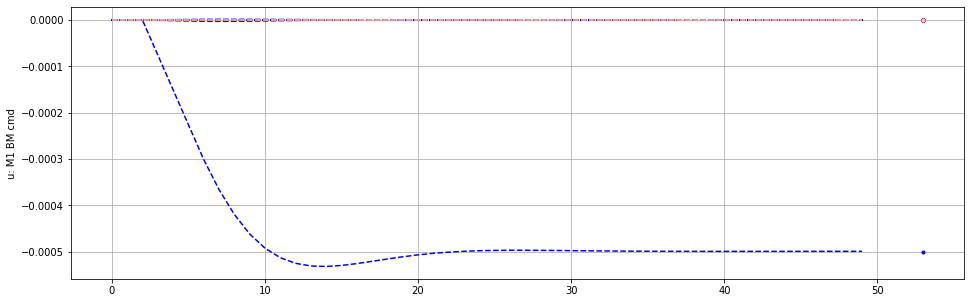

In [111]:
U = sim.logs.entries['AcO_controller']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

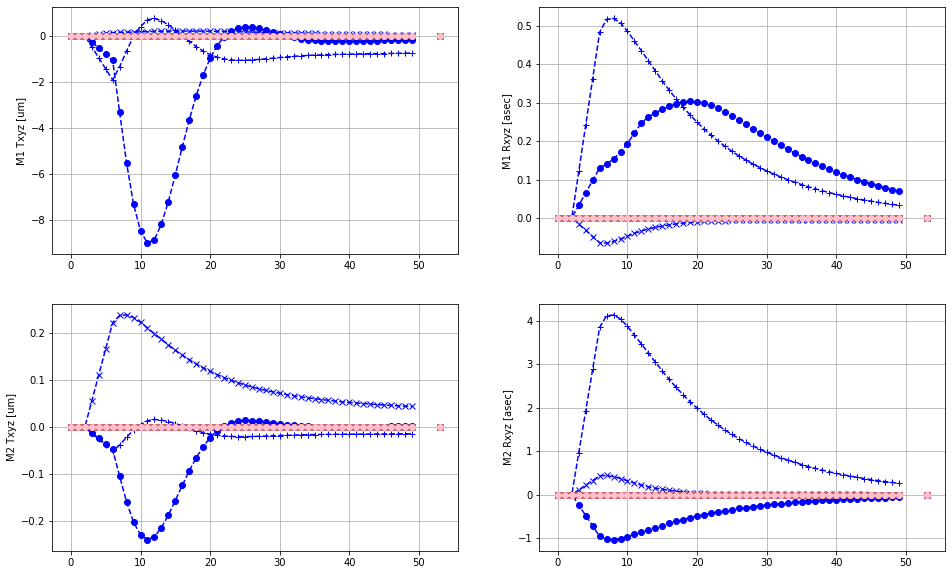

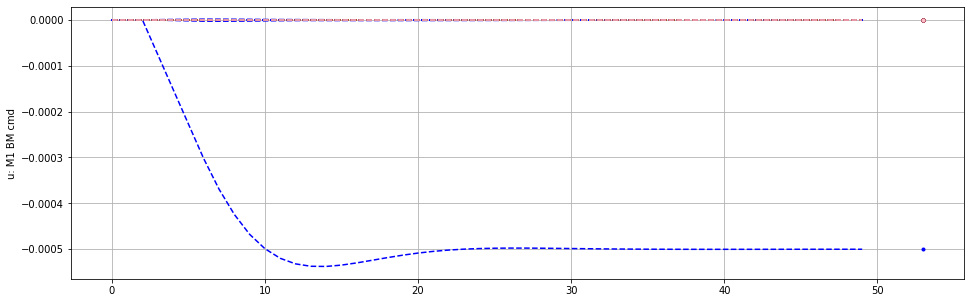

In [118]:
U = sim.logs.entries['AcO_controller']
show_delta = False
ptools.plot_X0loadComp(m1_x0_dt, m2_x0_dt, U, show_delta, colors, markers)

In [92]:
import scipy.io
if 'CG2HP' not in locals():
    CG2HP = scipy.io.loadmat('../ActiveOptics/CG2HP.mat')

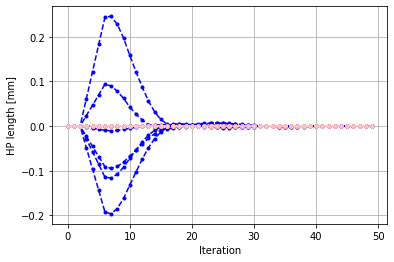

In [93]:
U = sim.logs.entries['AcO_controller']
#CG2HP['CG2HP_d'][0][0].shape
import matplotlib.pyplot as plt

m1_hp_d = []
for kk in range(7):
    m1TxyzRxyz = np.split(np.hstack([U['M1 Txyz'].timeSeries[1],
                                     U['M1 Rxyz'].timeSeries[1]]),7,axis=0)
    m1_hp_d.append(np.squeeze(CG2HP['CG2HP_d'][0][kk].dot(m1TxyzRxyz[kk])))
    plt.plot(m1_hp_d[kk].T*1.0e3,'.--', color = colors[kk])
plt.ylabel('HP length [mm]')
plt.xlabel('Iteration')
plt.grid()    

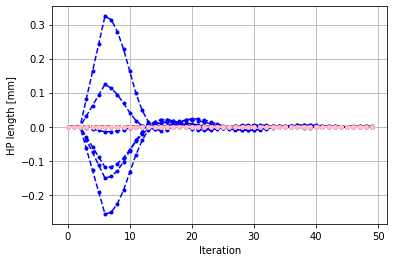

In [78]:
U = sim.logs.entries['AcO_controller']
#CG2HP['CG2HP_d'][0][0].shape
import matplotlib.pyplot as plt

m1_hp_d = []
for kk in range(7):
    m1TxyzRxyz = np.split(np.hstack([U['M1 Txyz'].timeSeries[1],
                                     U['M1 Rxyz'].timeSeries[1]]),7,axis=0)
    m1_hp_d.append(np.squeeze(CG2HP['CG2HP_d'][0][kk].dot(m1TxyzRxyz[kk])))
    plt.plot(m1_hp_d[kk].T*1.0e3,'.--', color = colors[kk])
plt.ylabel('HP length [mm]')
plt.xlabel('Iteration')
plt.grid()    

In [79]:
3.5e-6*(180/np.pi)*3600

0.7219268218648373

In [103]:
# Test cases in which REQ-L4-M1S-51833 seems misleading, according 
#to the CG2HP matrix of build3 fem
M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,650e-6,575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

M1RBMmax = np.array([3.0e-3,4.75e-3,4.0e-3,0*650e-6,0*575e-6,575e-6])
print('HP lengths',CG2HP['CG2HP_d'][0][0].dot(M1RBMmax)*1.0e3)

HP lengths [ 6.15074717  2.42595625  2.38654281  5.98007822  3.34834477 -3.78004005]
HP lengths [ 7.96706706  2.71784883  1.4437542   4.29725283  2.50323777 -2.38093131]


In [98]:
np.array([[0.38, 40],[3, 330]])/3600*(np.pi/180)

array([[1.84229199e-06, 1.93925472e-04],
       [1.45444104e-05, 1.59988515e-03]])

#### Reconstructed states

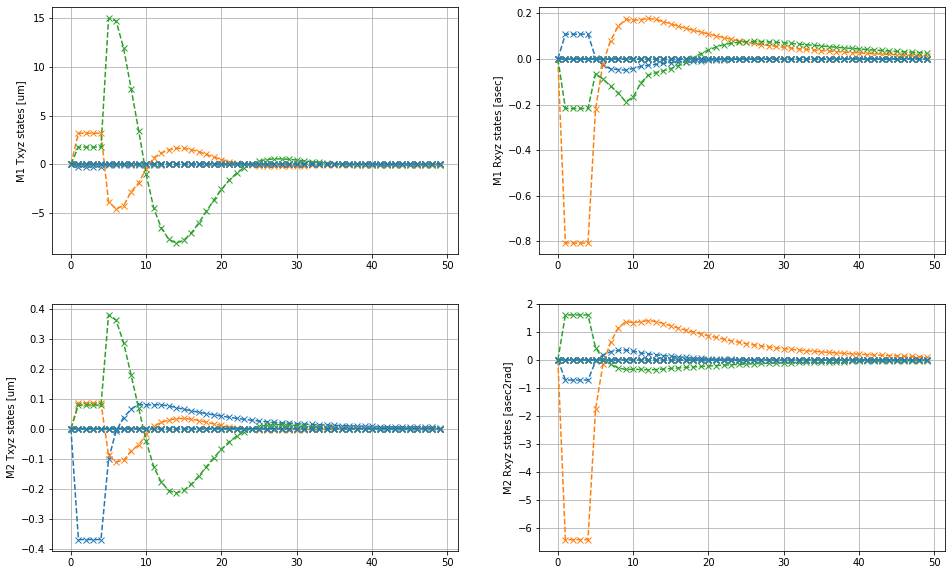

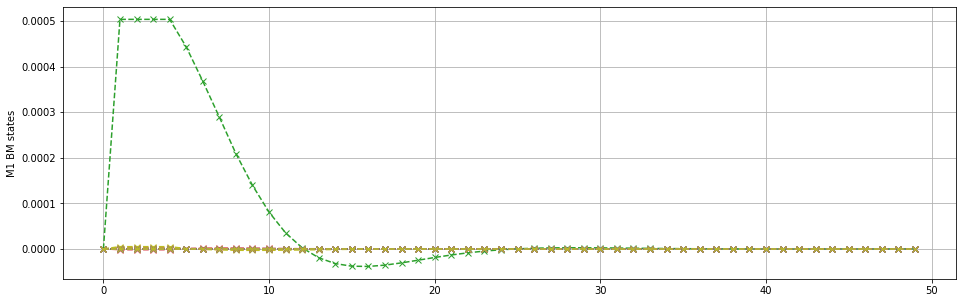

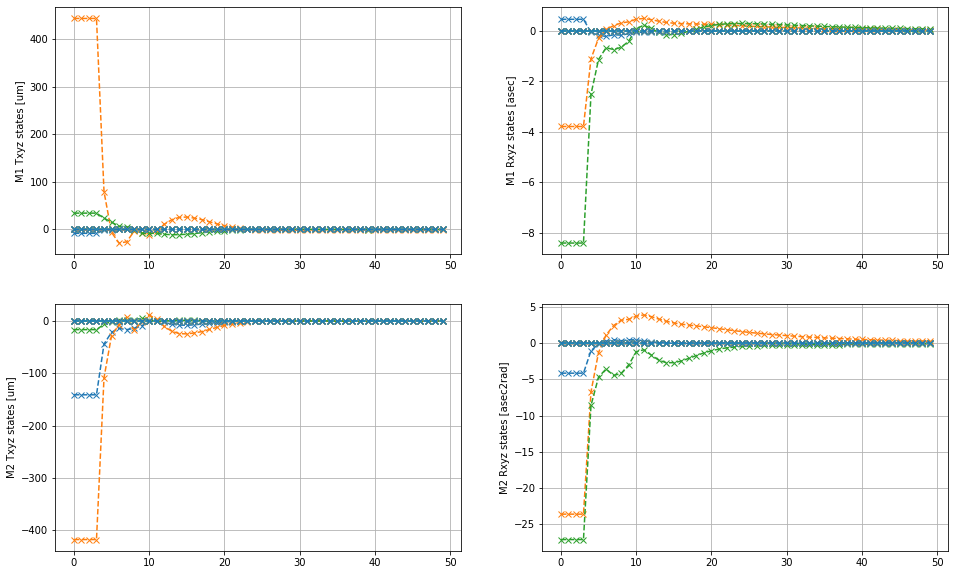

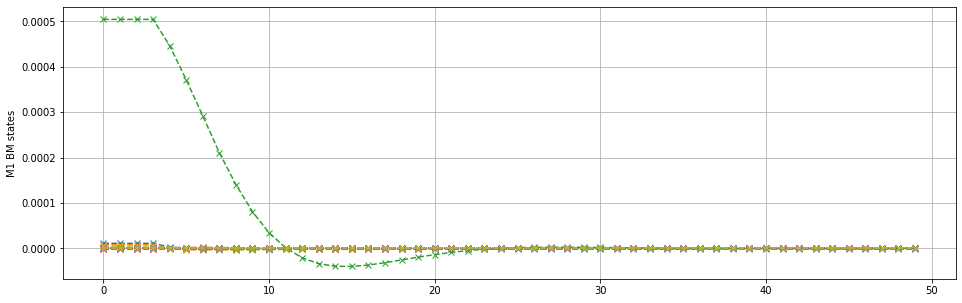

In [119]:
ptools.plot_states(sim.logs.entries['ReconstructorM']['x_hat'].timeSeries, n_bm)
ptools.plot_states(sim.logs.entries['wfs48']['M12_RBM'].timeSeries, n_bm)

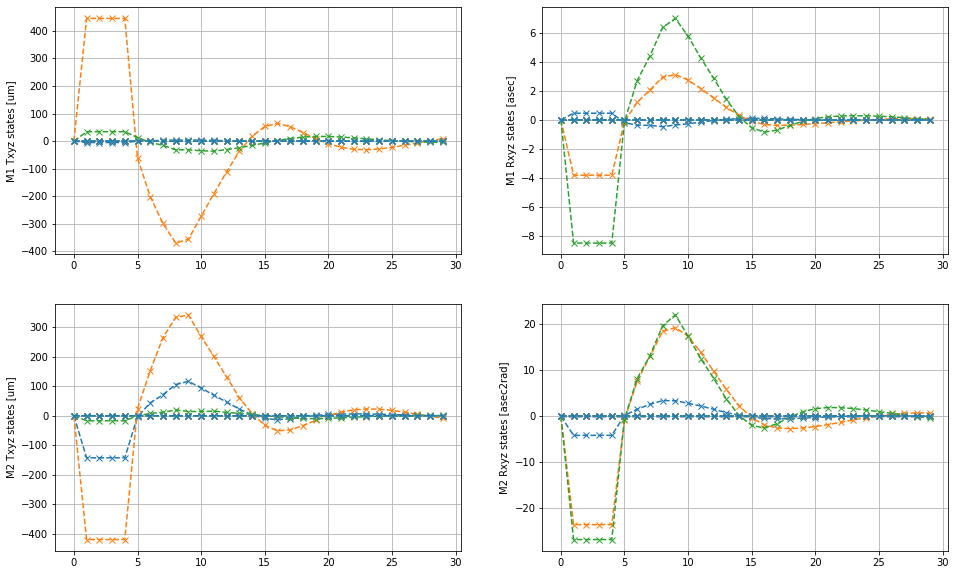

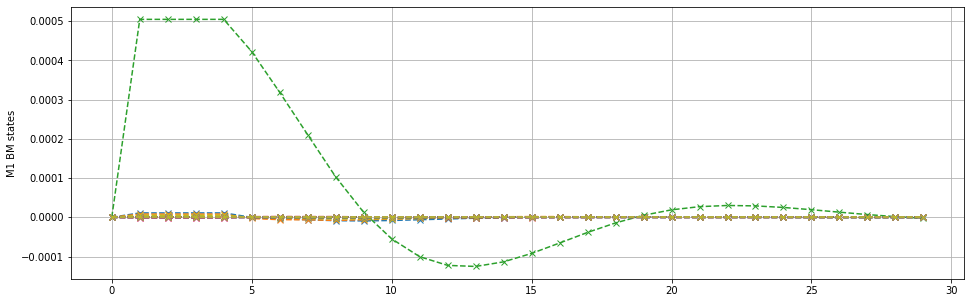

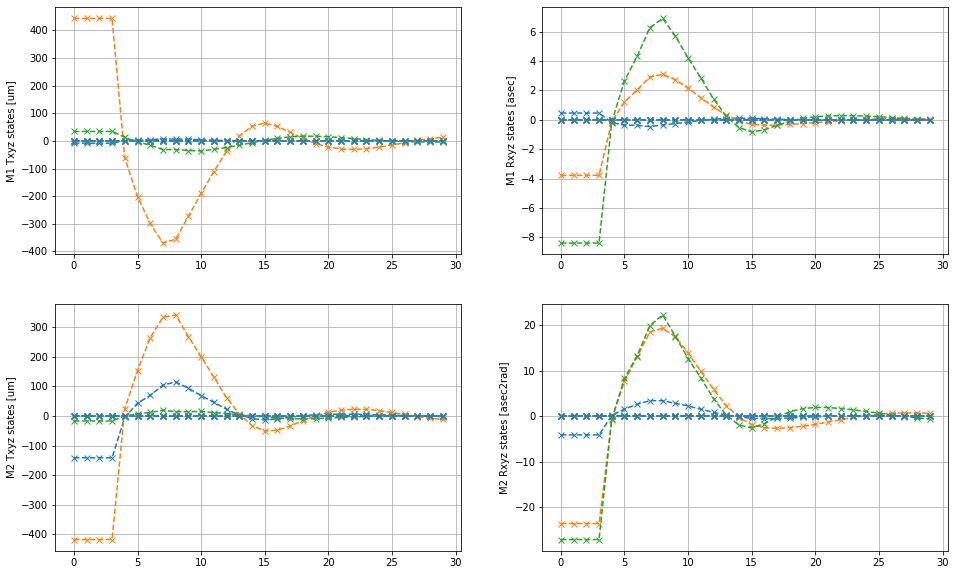

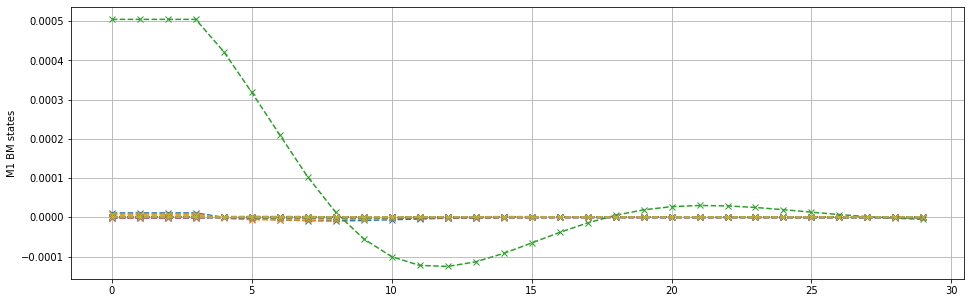

In [81]:
ptools.plot_states(sim.logs.entries['ReconstructorM']['x_hat'].timeSeries, n_bm)
ptools.plot_states(sim.logs.entries['wfs48']['M12_RBM'].timeSeries, n_bm)

In [133]:
np.array(m1_x0_dt['state']['Txyz'])

array([[ 6.28802548e-05,  5.90844324e-03, -2.46650884e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [135]:
np.reshape(np.array(m1_x0_dt['state']['Txyz']),(21,1))

array([[ 6.28802548e-05],
       [ 5.90844324e-03],
       [-2.46650884e-03],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])